In [2]:
!pip install -r requirements.txt
# !pip install tensorflow yfinance pandas sklearn

In [3]:
import pandas as pd
import tensorflow as tf
import yfinance as yf

In [4]:
from datetime import datetime, timedelta
end_date = datetime.today().strftime('%Y-%m-%d')
start_date_dt = datetime.now() - timedelta(days=10*365)
start_date = start_date_dt.strftime('%Y-%m-%d')
fb = yf.download("FB", start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
df = pd.DataFrame(fb)
df1 = df.reset_index()['Close']

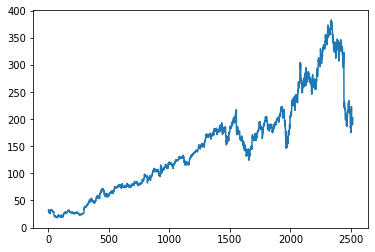

In [6]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [8]:
# Split data
train_size = int(len(df1)*.95) # 95%
test_size = len(df1) - train_size
train, test = df1[0:train_size,:], df1[train_size:len(df1), :1]

In [9]:
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [11]:
print(X_test.shape), print(y_test.shape)

(25, 100)
(25,)


(None, None)

In [12]:
# Reshape to be inputted into LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
# Create Stacked LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(Dropout(.5))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-traina

In [15]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=250, verbose=1)

Epoch 1/100
10/10 [==============================] - 10s 469ms/step - loss: 0.0590 - val_loss: 0.0092
Epoch 2/100
10/10 [==============================] - 3s 320ms/step - loss: 0.0145 - val_loss: 0.0216
Epoch 3/100
10/10 [==============================] - 4s 356ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 4/100
10/10 [==============================] - 4s 367ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 5/100
10/10 [==============================] - 4s 377ms/step - loss: 0.0017 - val_loss: 0.0075
Epoch 6/100
10/10 [==============================] - 4s 371ms/step - loss: 0.0014 - val_loss: 0.0055
Epoch 7/100
10/10 [==============================] - 4s 365ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 8/100
10/10 [==============================] - 4s 380ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 9/100
10/10 [==============================] - 4s 389ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 10/100
10/10 [==============================] - 4s 382ms/step - loss: 0.0012 - val_l

In [16]:
prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

In [17]:
prediction = scaler.inverse_transform(prediction)
test_prediction = scaler.inverse_transform(test_prediction)

In [18]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, prediction))

168.4582491803923

In [19]:
math.sqrt(mean_squared_error(y_test, test_prediction))

207.4924977159398

In [21]:
x_input = test[len(test)-100:].reshape(1, -1)
x_input.shape

(1, 100)

In [22]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [23]:
# Prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while i<30:

    if len(temp_input)>100:
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

1 day input [0.89233093 0.89622717 0.8742489  0.88025796 0.87474278 0.8408287
 0.86357524 0.8617369  0.85152974 0.86881603 0.86577038 0.84716701
 0.86203869 0.82431061 0.82826177 0.81994788 0.78320763 0.79840855
 0.77492111 0.75977503 0.7598025  0.77920153 0.81089317 0.8266429
 0.83761835 0.60373165 0.60189327 0.56847306 0.55549457 0.58792703
 0.57714367 0.55376597 0.54868981 0.55774456 0.54550692 0.52127867
 0.51702568 0.50583072 0.49587049 0.52097684 0.52887913 0.53038826
 0.50969957 0.5223762  0.50827275 0.50028811 0.46574291 0.47348058
 0.49600769 0.48698041 0.46612705 0.46343808 0.47825491 0.51008371
 0.52163534 0.54536976 0.53165046 0.54580875 0.53705587 0.55382086
 0.55999454 0.56485115 0.58205517 0.57654002 0.56147621 0.56830844
 0.59311292 0.587488   0.56405545 0.56309508 0.5613939  0.54528745
 0.53892167 0.54125397 0.52805597 0.52967488 0.54761971 0.5012759
 0.46738925 0.45652354 0.46442587 0.44785293 0.43138977 0.51584579
 0.5014131  0.53066267 0.53313212 0.56435727 0.522842

In [24]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [25]:
print(scaler.inverse_transform(lst_output[0:]))

[[200.87037791]
 [200.23128983]
 [199.64014422]
 [199.15734163]
 [198.80647315]
 [198.58371554]
 [198.46901856]
 [198.43582595]
 [198.45760317]
 [198.5116715 ]
 [198.58093501]
 [198.65394572]
 [198.72379574]
 [198.78729182]
 [198.84345641]
 [198.89282172]
 [198.93647392]
 [198.9757055 ]
 [199.01166778]
 [199.04519709]
 [199.07705374]
 [199.10767219]
 [199.13718277]
 [199.16593304]
 [199.19386871]
 [199.22115268]
 [199.24775239]
 [199.27383075]
 [199.29929   ]
 [199.3243691 ]]


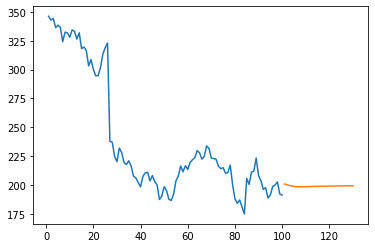

In [26]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

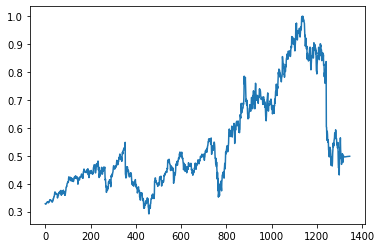

In [27]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [28]:
df3=scaler.inverse_transform(df3).tolist()

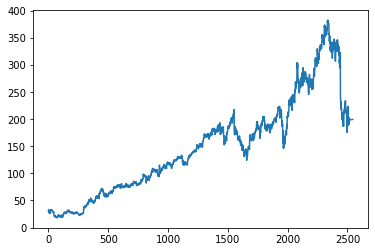

In [29]:
plt.plot(df3)

In [30]:
import time
from datetime import datetime

SECONDS_IN_DAY = 86400

now = int( time.time() )

data_set = {"c": [], "t": []}
inversed_output = scaler.inverse_transform(lst_output)
inversed_output.tolist()
for i in range(len(inversed_output)):
    now = SECONDS_IN_DAY + now
    data_set["c"].insert(i, round(float(inversed_output[i]), 2))
    data_set["t"].insert(i, int(now))

In [31]:
import json
with open('../src/stock_json/fb.json', 'w', encoding='utf-8') as f:
    json.dump(data_set, f, ensure_ascii=False, indent=4)